## Task 0 - Exploratory Data Analysis and Data Preparation
Before building up our machine learning model, we would conduct exploratory data analysis and prepare the data at first.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
#matplotlib set up
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('ggplot')

In [3]:
#set seed to ensure model reproducibility
SEED = 369

In [4]:
#make sure to display all the columns of a dataset
pd.set_option('display.max_columns', None)

In [5]:
#load the data
retail_original = pd.read_csv('03_Retail_Clustering.csv', sep=';')

In [6]:
#first five records
retail_original.head()

,Year_Birth,Education,Marital_Status,Estimated_Income,Kid_home,Teen_home,Registration_date,Recency,Exist_Complain,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
0,1957,Graduation,Single,58138.0,0,0,04.09.2020,58,0,635,88,546,172,88,88,8,10,4
1,1954,Graduation,Single,46344.0,1,1,08.03.2022,38,0,11,1,6,2,1,6,1,1,2
2,1965,Graduation,Together,71613.0,0,0,21.08.2021,26,0,426,49,127,111,21,42,8,2,10
3,1984,Graduation,Together,26646.0,1,0,10.02.2022,26,0,11,4,20,10,3,5,2,0,4
4,1981,PhD,Married,58293.0,1,0,19.01.2022,94,0,173,43,118,46,27,15,5,3,6


In [7]:
#last five records
retail_original.tail()

,Year_Birth,Education,Marital_Status,Estimated_Income,Kid_home,Teen_home,Registration_date,Recency,Exist_Complain,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
2235,1967,Graduation,Married,61223.0,0,1,13.06.2021,46,0,709,43,182,42,118,247,9,3,4
2236,1946,PhD,Together,64014.0,2,1,10.06.2022,56,0,406,0,30,0,0,8,8,2,5
2237,1981,Graduation,Divorced,56981.0,0,0,25.01.2022,91,0,908,48,217,32,12,24,2,3,13
2238,1956,Master,Together,69245.0,0,1,24.01.2022,8,0,428,30,214,80,30,61,6,5,10
2239,1954,PhD,Married,52869.0,1,1,15.10.2020,40,0,84,3,61,2,1,21,3,1,4


In [8]:
#a summary of all columns
retail_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Estimated_Income     2216 non-null   float64
 4   Kid_home             2240 non-null   int64  
 5   Teen_home            2240 non-null   int64  
 6   Registration_date    2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   Exist_Complain       2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

In the preceding output, we can see that there are 2240 rows and 18 columns in the data. Out of these, 1 column (`Estimated_Income`) has missing values, 3 columns (`Education`, `Marital_Status` and `Registration_date`) are Strings, 1 column is float, and 14 are of datatype integer. Note that the values of `Registration_date` should be converted to datetime object to reflect the date of registration.

We will then manipulate the data.

In [9]:
#make of copy of the original dataset to ensure it remains unchanged during the following analysis
retail = retail_original.copy()

In [10]:
#convert to datetime
retail['Registration_date'] = pd.to_datetime(retail_original.Registration_date, format='%d.%m.%Y')
retail['Registration_date'].head()

0   2020-09-04
1   2022-03-08
2   2021-08-21
3   2022-02-10
4   2022-01-19
Name: Registration_date, dtype: datetime64[ns]

This looks fine but only a registration date won't be very helpful for a meaningful clustering, because what is actually useful for us is the membership duration of a customer, so we will further convert `Registration_date` to a new column `Member_days` which represents the membership duration in days (the same unit as `Recency` column. We define the duration as the time span in days between the registration of a customer and the present date, which we will take "2023-01-01" (we will avoid the approach like "date.today()" which is a non-deterministic function because it returns a different value on a different day when this notebook is run. We thus specify the date as "2023-01-01" just to ensure that the output of the analysis in this project will be the same even when the script is run at a different time in the future.)

In [11]:
#assign the value of the present date
today = datetime(2023, 1, 1)
today

datetime.datetime(2023, 1, 1, 0, 0)

In [12]:
retail['Member_days'] = (today - retail.Registration_date).apply(lambda x: x.days)
retail['Member_days']

0       849
1       299
2       498
3       325
4       347
       ... 
2235    567
2236    205
2237    341
2238    342
2239    808
Name: Member_days, Length: 2240, dtype: int64

Then drop the `Registration_date` column.

In [13]:
retail.drop('Registration_date', axis=1, inplace=True)

Here, will verify the data consistency - make sure that the number of days since customer's last purchase is no longer than the duration of the customer's membership:

In [14]:
#no inconsistency
sum(retail.Member_days < retail.Recency)

0

Then, take a look at the descriptive statistics of the data using the describe function.

In [15]:
retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Estimated_Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kid_home,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teen_home,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
Exist_Complain,2240.0,0.009375,0.096391,0.0,0.00,0.0,0.00,1.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


From these results, we can see the central tendency as well as the range of the numerical data. We can already tell that the column `Year_Birth` needs further analysis because there seems to be outliers, for an active customer is highly unlikely to be born in 1893. Let's also have a look at the descriptive statistics of the columns of "object" datatype:

In [16]:
retail.describe(include='O').T

,count,unique,top,freq
Education,2240,5,Graduation,1127
Marital_Status,2240,8,Married,864


We can see that most of the customers are with graduation and are married. Then check unique values of the `Education`, `Marital_Status`, `Kid_home`, `Teen_home` and `Exist_Complain` column to see if there are any unreasonable and noisy data.

In [17]:
print('Unique values of column "Education": {}'.format(retail.Education.unique()))
print('Unique values of column "Marital_Status": {}'.format(retail.Marital_Status.unique()))
print('Unique values of column "Kids_home": {}'.format(retail.Kid_home.unique()))
print('Unique values of column "Teen_home": {}'.format(retail.Teen_home.unique()))
print('Unique values of column "Exist_Complain": {}'.format(retail.Exist_Complain.unique()))

Unique values of column "Education": ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Unique values of column "Marital_Status": ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Unique values of column "Kids_home": [0 1 2]
Unique values of column "Teen_home": [0 1 2]
Unique values of column "Exist_Complain": [0 1]


As the `Exist_Complain` column should be categorical by nature, we will convert its datatype from "int" to "categorical":

In [18]:
retail['Exist_Complain'] = retail.Exist_Complain.astype('category')

Also, we see that there are too many unique values in `Marital_Status`, which carry redundant information and could be misleading for the clustering later on. To keep these values simple, we will change the data in as follows:
- 'Married’,'Together'should be labeled 'Relationship'
- 'Divorced','Widow','Alone','YOLO','Absurd' should be labeled 'Single'

In [19]:
#Create mappings and replace
mappings = {
            'Married':'Relationship', 
            'Together':'Relationship',
            'Divorced':'Single', 
            'Widow':'Single', 
            'Alone':'Single', 
            'YOLO':'Single', 
            'Absurd':'Single'
}
retail['Marital_Status'] = retail.Marital_Status.replace(mappings)

#check the unique values again
print(retail.Marital_Status.unique())

['Single' 'Relationship']


### Feature Extraction
Apart from removing redundant information in a single column as above, we can also combine similar columns into one single column to reduce the dimension of the dataset. For instance, we will add a new column `Children`, which is the number of children, i.e. "kids" or "teenagers" in customer's household and delete the two original columns `Kid_home` and `Teen_home`.

In [20]:
retail['Children'] = retail.Kid_home + retail.Teen_home
retail.drop(columns=['Kid_home', 'Teen_home'], inplace=True)

In [21]:
#check the first lines again
retail.head()

,Year_Birth,Education,Marital_Status,Estimated_Income,Recency,Exist_Complain,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Member_days,Children
0,1957,Graduation,Single,58138.0,58,0,635,88,546,172,88,88,8,10,4,849,0
1,1954,Graduation,Single,46344.0,38,0,11,1,6,2,1,6,1,1,2,299,2
2,1965,Graduation,Relationship,71613.0,26,0,426,49,127,111,21,42,8,2,10,498,0
3,1984,Graduation,Relationship,26646.0,26,0,11,4,20,10,3,5,2,0,4,325,1
4,1981,PhD,Relationship,58293.0,94,0,173,43,118,46,27,15,5,3,6,347,1


### Handel Missing Values

In [22]:
retail.isna().any()

Year_Birth             False
Education              False
Marital_Status         False
Estimated_Income        True
Recency                False
Exist_Complain         False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
Member_days            False
Children               False
dtype: bool

Consistent with our perious overview, `Estimated_Income` column has missing values. We could simply replace the NAN with the mean of it, however, to make the outcome more precise, as we assume that the income level of a customer is affected by his or her level of education, we will instead calculate the average income of customers of groups with different educations, and then replace the `Estimated_Income` null values with the mean `Estimated_Income` value of that particular customer group.

In [23]:
#display the average income of each education group
income_groups = retail.groupby('Education').Estimated_Income.mean()
income_groups

Education
2n Cycle      47633.190000
Basic         20306.259259
Graduation    52720.373656
Master        52917.534247
PhD           56145.313929
Name: Estimated_Income, dtype: float64

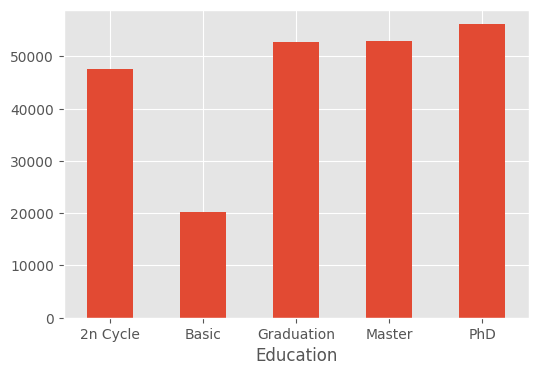

In [24]:
#visualize the result above
income_groups.plot(kind='bar', rot=0, figsize=(6,4))
plt.show()

Indeed, `Estimated_Income` varies among customers with different educational qualifications as this bar plot suggests.

In [25]:
#display the unique values of the educations of the missing data
retail.loc[retail.Estimated_Income.isna(), 'Education'].unique()

array(['Graduation', 'PhD', '2n Cycle', 'Master'], dtype=object)

We define a function to replace missing data with average income value of different groups:

In [26]:
def impute_income(cols):
    '''
    returns the average income of different educational level groups
    '''
    education = cols[0]
    income = cols[1]
    
    if pd.isna(income):
        
        if education == 'Graduation':
            return income_groups['Graduation']
        elif education == 'PhD':
            return income_groups['PhD']
        elif education == '2n Cycle':
            return income_groups['2n Cycle']
        elif education == 'Master':
            return income_groups['Master']
        
    else:
        return income

In [27]:
#apply the impute function above
retail['Estimated_Income'] = retail[['Education', 'Estimated_Income']].apply(impute_income, axis=1)

In [28]:
#check na again
retail.Estimated_Income.isna().any()

False

No more missing values in `Estimated_Income` column.

Just as the original `Marital_Status` column, `Education` column also contains redundant information, for example "2n Cycle" is just another name of "Master". For this reason, we would change the "2n Cycle" to "Master" (More information about "2n Cycle" please refer to [here](https://www.studera.nu/startpage/higher-education-studies/higher-education-in-sweden/study-levels-and-degrees/#)). Moreover, we will rename "Graduation" to "Bachelor" to make it's meaning clearer (for more info refer to [here](https://www.quora.com/What-is-graduation-post-graduation-and-undergraduation-Im-little-confused?no_redirect=1)). Moreover, here is an explanation of ["Basic"](https://uis.unesco.org/en/glossary-term/basic-education) education.

In [29]:
#Create mappings and replace
edu_mappings = {
            '2n Cycle':'Master', 
            'Graduation':'Bachelor'
}
retail['Education'] = retail.Education.replace(edu_mappings)

#check the unique values again
print(retail.Education.unique())

['Bachelor' 'PhD' 'Master' 'Basic']


### Check and Remove Outliers

As we will conduct K-means clustering later on, and K-means algorithms can be quite sensitive to outliers. We will therefore use boxplots to detect the potential outliers as individual points and then remove them. Let's look at the `Year_Birth` column first.

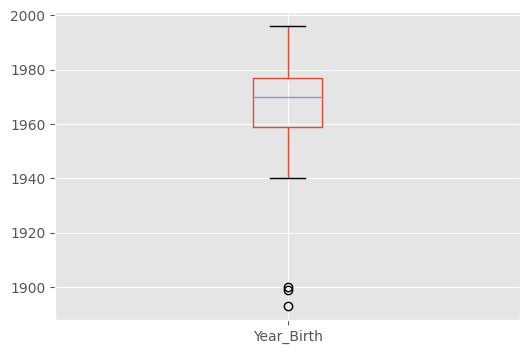

In [30]:
#display the outliers of Year_Birth
retail.boxplot('Year_Birth', figsize=(6, 4))
plt.show()

In [31]:
retail.Year_Birth.sort_values()

239     1893
339     1899
192     1900
1950    1940
424     1941
        ... 
747     1995
1850    1995
696     1995
1170    1996
46      1996
Name: Year_Birth, Length: 2240, dtype: int64

An active customer with the year of birth beyond 1900 is highly unlikely and we treat these data as noises and thus drop these observations.

In [32]:
retail.drop(index=retail[retail.Year_Birth <= 1900].index, inplace=True)

In [33]:
#unreasonable age cleaned
retail.loc[retail.Year_Birth <= 1900, 'Year_Birth'].count()

0

Like the registration date of a customer, the year of birth alone also doesn't give us much information, we will instead convert the year of birth values to the age of the customers (new column `Age`) and drop the original column:

In [34]:
#new column age
retail['Age'] = today.year - retail.Year_Birth

#drop original column
retail.drop('Year_Birth', axis=1, inplace=True)

For the other numerical columns, we log-scale the y-axis to make the boxplot more readable.

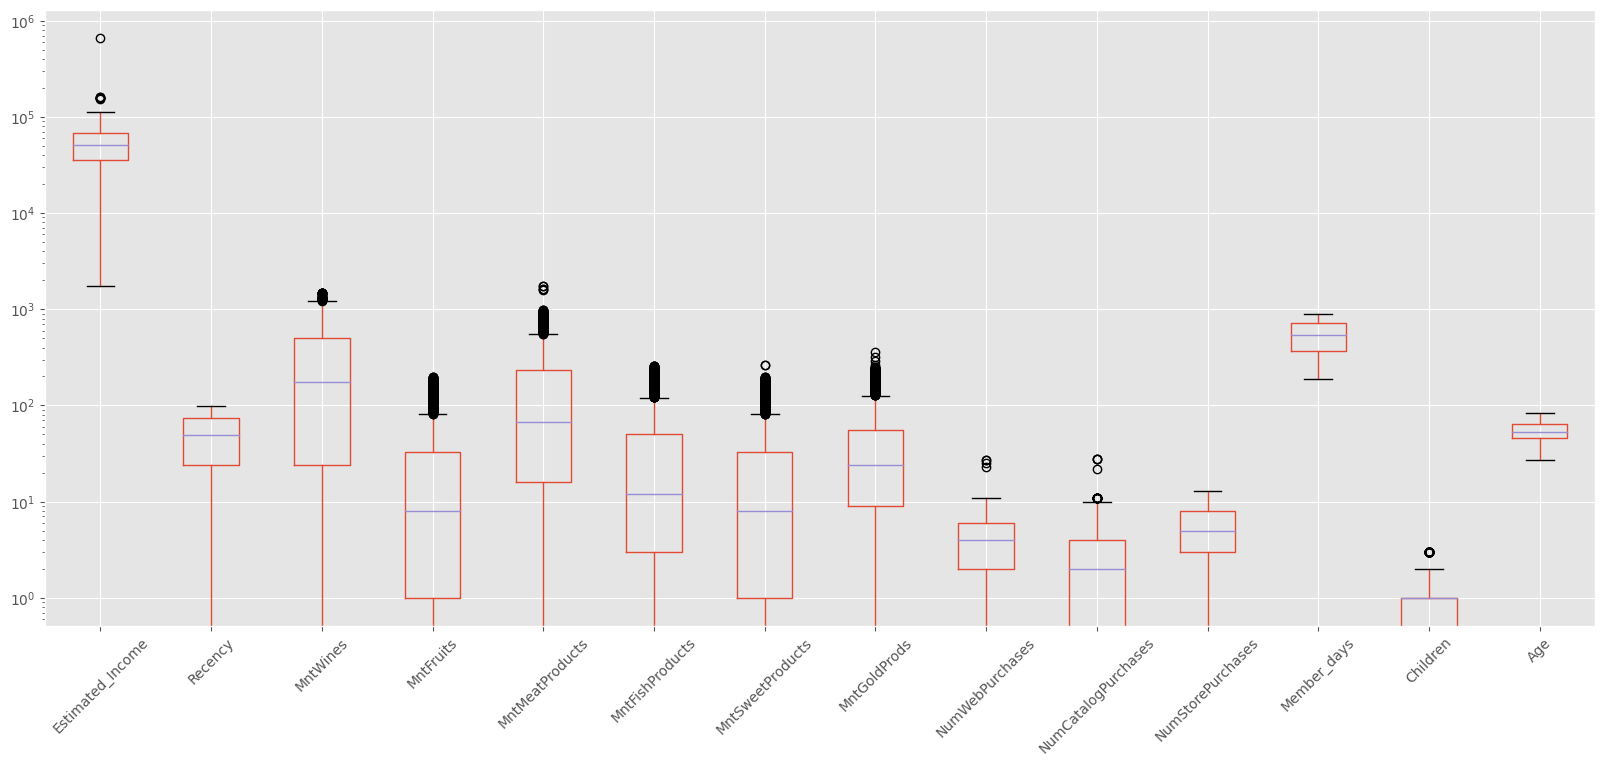

In [35]:
plt.figure(figsize=(20,8))
retail.select_dtypes(np.number).boxplot(rot=45)
plt.yscale('log')
plt.show()

In [36]:
#unique values in "Children" column
retail.Children.unique()

array([0, 2, 1, 3])

As the boxplots suggest, there are outliers in the dataset (dots beyond the Whiskers). However, these outliers are valid data points derived from a heavy-tailed distribution or rare events, so we will use the "winsorizing" technique to handle them by replacing all the outliers with the inter quartile range multiplied by 1.5, i.e. 1.5 x (q75% - q25%) (Inter-quartile-range rule). In this way, we can keep all observations remain in the dataset that may contain useful information. Please note that we won't manipulate the values in `Children` column as it has only 4 values (0,1,2,3) and all of them make sense.

We will create a winsorizing() function and perform the manipulation on the above mentioned columns:

In [37]:
def winsorizing(df, column):
    '''
    use the "winsorizing" technique to replace outliers of a column 
    with the inter quartile range multiplied by 1.5
    '''
    q25, q75 = np.quantile(df[column], [0.25, 0.75])
    iqr = q75 - q25 #inter quartile range
    lower_limit, upper_limit = q25 - 1.5*iqr, q75 + 1.5*iqr
    
    df.loc[df[column] < lower_limit, column] = lower_limit
    df.loc[df[column] > upper_limit, column] = upper_limit
    print(f'The "{column}" column is winsorized.')

In [38]:
#the columns to be manipulated
column_towinsorize = list(retail.select_dtypes(np.number).columns)
column_towinsorize.remove('Children') # exclude "Children" column
column_towinsorize

['Estimated_Income',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'Member_days',
 'Age']

In [39]:
#perform winsorizing
for column in column_towinsorize:
    winsorizing(retail, column)

The "Estimated_Income" column is winsorized.
The "Recency" column is winsorized.
The "MntWines" column is winsorized.
The "MntFruits" column is winsorized.
The "MntMeatProducts" column is winsorized.
The "MntFishProducts" column is winsorized.
The "MntSweetProducts" column is winsorized.
The "MntGoldProds" column is winsorized.
The "NumWebPurchases" column is winsorized.
The "NumCatalogPurchases" column is winsorized.
The "NumStorePurchases" column is winsorized.
The "Member_days" column is winsorized.
The "Age" column is winsorized.


Let's view the winsorized dataset:

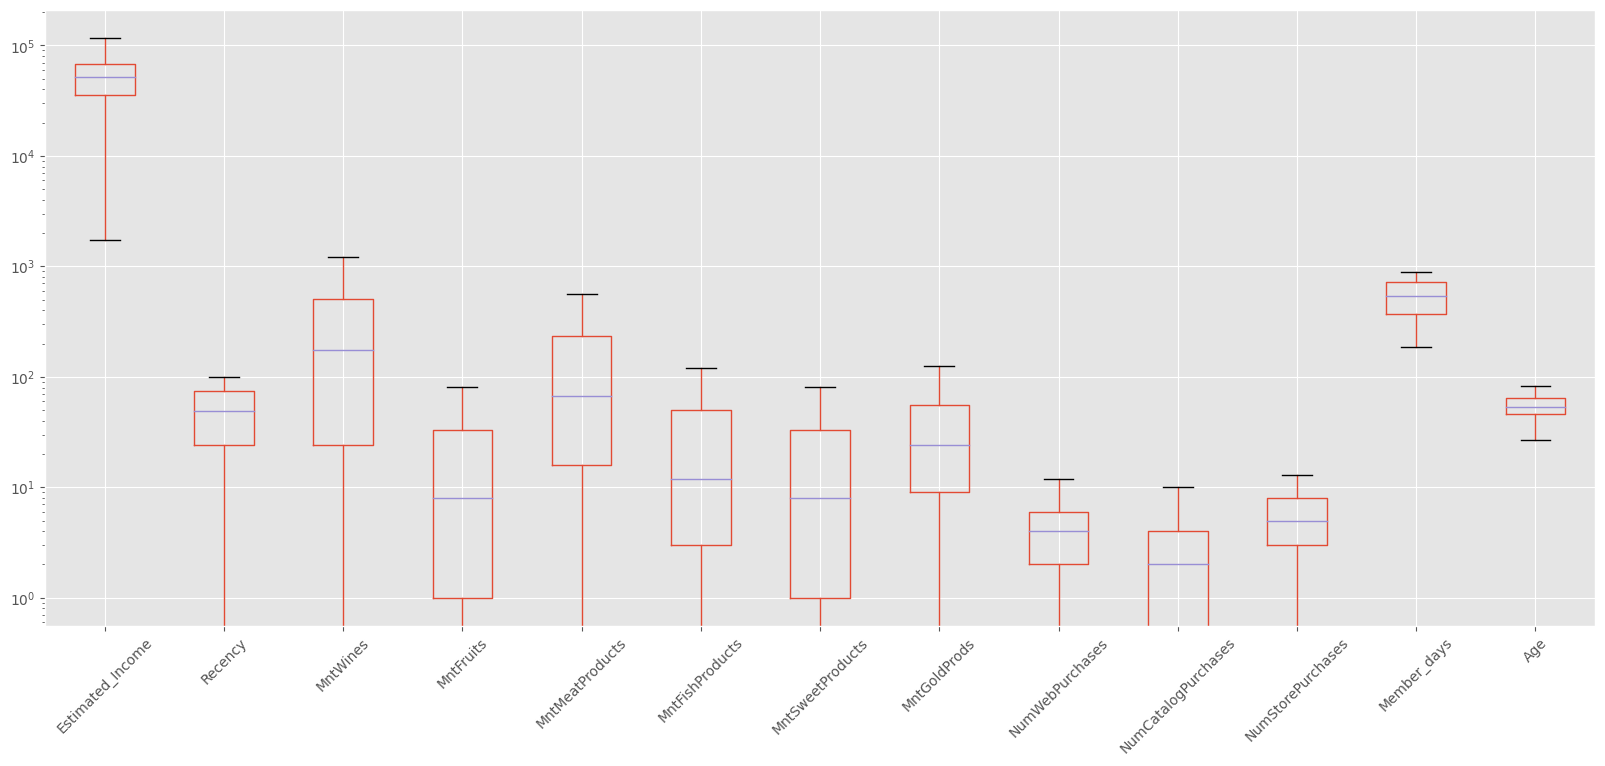

In [40]:
plt.figure(figsize=(20,8))
retail[column_towinsorize].boxplot(rot=45)
plt.yscale('log')
plt.show()

As the boxplot of the new dataset suggests, we removed the outliers. Let's have a final view of our prepared dataset:

In [41]:
retail.head()

,Education,Marital_Status,Estimated_Income,Recency,Exist_Complain,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Member_days,Children,Age
0,Bachelor,Single,58138.0,58,0,635,81,546,120.5,81,88.0,8,10,4.0,849,0,66
1,Bachelor,Single,46344.0,38,0,11,1,6,2.0,1,6.0,1,1,2.0,299,2,69
2,Bachelor,Relationship,71613.0,26,0,426,49,127,111.0,21,42.0,8,2,10.0,498,0,58
3,Bachelor,Relationship,26646.0,26,0,11,4,20,10.0,3,5.0,2,0,4.0,325,1,39
4,PhD,Relationship,58293.0,94,0,173,43,118,46.0,27,15.0,5,3,6.0,347,1,42


In [42]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2239
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2237 non-null   object  
 1   Marital_Status       2237 non-null   object  
 2   Estimated_Income     2237 non-null   float64 
 3   Recency              2237 non-null   int64   
 4   Exist_Complain       2237 non-null   category
 5   MntWines             2237 non-null   int64   
 6   MntFruits            2237 non-null   int64   
 7   MntMeatProducts      2237 non-null   int64   
 8   MntFishProducts      2237 non-null   float64 
 9   MntSweetProducts     2237 non-null   int64   
 10  MntGoldProds         2237 non-null   float64 
 11  NumWebPurchases      2237 non-null   int64   
 12  NumCatalogPurchases  2237 non-null   int64   
 13  NumStorePurchases    2237 non-null   float64 
 14  Member_days          2237 non-null   int64   
 15  Children             

In [43]:
retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Estimated_Income,2237.0,51870.451909,20937.880606,1730.0,35523.0,51569.0,68281.0,117418.0
Recency,2237.0,49.104604,28.956073,0.0,24.0,49.0,74.0,99.0
MntWines,2237.0,302.154671,330.983171,0.0,24.0,174.0,504.0,1224.0
MntFruits,2237.0,21.669200,27.240885,0.0,1.0,8.0,33.0,81.0
MntMeatProducts,2237.0,150.821189,178.679174,0.0,16.0,67.0,232.0,556.0
MntFishProducts,2237.0,32.106169,40.352941,0.0,3.0,12.0,50.0,120.5
MntSweetProducts,2237.0,21.936969,27.537924,0.0,1.0,8.0,33.0,81.0
MntGoldProds,2237.0,39.472061,39.902834,0.0,9.0,24.0,56.0,126.5
NumWebPurchases,2237.0,4.063031,2.647957,0.0,2.0,4.0,6.0,12.0
NumCatalogPurchases,2237.0,2.624497,2.734901,0.0,0.0,2.0,4.0,10.0


In [44]:
retail.describe(include=['O', 'category']).T

,count,unique,top,freq
Education,2237,4,Bachelor,1127
Marital_Status,2237,2,Relationship,1443
Exist_Complain,2237,2,0,2217


Now that we engineered the features, replaced the null values and handeled the outliers, it is a good starting point for cluster analysis with K-means algorithm. As the last step of data preparation, we will create a processing pipeline containing the transformation of all the categorical features with one-hot encoding and the numerical features with standard-scaler, because we have to ensure that all features are measured on the same scale.

In [45]:
#create a preprocessing pipeline
preprocessing = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_exclude=np.number))
], remainder=StandardScaler(), verbose_feature_names_out=False)

## Task 1
Cluster the existing data based on appropriate procedures.

In [46]:
#check the preprocessing pipeline
pd.DataFrame(preprocessing.fit_transform(retail), columns=preprocessing.get_feature_names_out()).head()

,Education_Bachelor,Education_Basic,Education_Master,Education_PhD,Marital_Status_Relationship,Marital_Status_Single,Exist_Complain_0,Exist_Complain_1,Estimated_Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Member_days,Children,Age
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.299407,0.307272,1.005851,2.178493,2.212161,2.191007,2.145268,1.216425,1.487127,2.697411,-0.552077,1.530038,-1.264618,1.017296
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.264004,-0.383584,-0.879863,-0.758926,-0.810691,-0.746238,-0.760466,-0.839027,-1.157011,-0.594120,-1.167421,-1.191484,1.395420,1.273722
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.943121,-0.798098,0.374258,1.003525,-0.133348,1.955532,-0.034032,0.063367,1.487127,-0.228395,1.293956,-0.206788,-1.264618,0.333495
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.204997,-0.798098,-0.879863,-0.648773,-0.732321,-0.547943,-0.687822,-0.864093,-0.779277,-0.959846,-0.552077,-1.062830,0.065401,-1.290534
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.306812,1.550812,-0.390302,0.783219,-0.183729,0.344385,0.183898,-0.613428,0.353925,0.137331,0.063267,-0.953970,0.065401,-1.034108


Our processing pipeline functions well, we can now build and train the K-means clusterer.

Since the number of clusters (k) influences the clustering results a lot, we will experimentally find the optimal k by using the following 3 approaches:
- elbow method - plotting the inertia as a function of the number of clusters k
- plotting silhouette score and k
- silhouette diagram

### Elbow Method

In [47]:
#define the range of k and compute the inertias within this range
k_range = range(1, 50)
#a list of models
kmeans_per_k = [make_pipeline(preprocessing, 
                              KMeans(n_clusters=k, n_init=10, random_state=SEED)).fit(retail) for k in k_range]
inertias = [model[-1].inertia_ for model in kmeans_per_k]

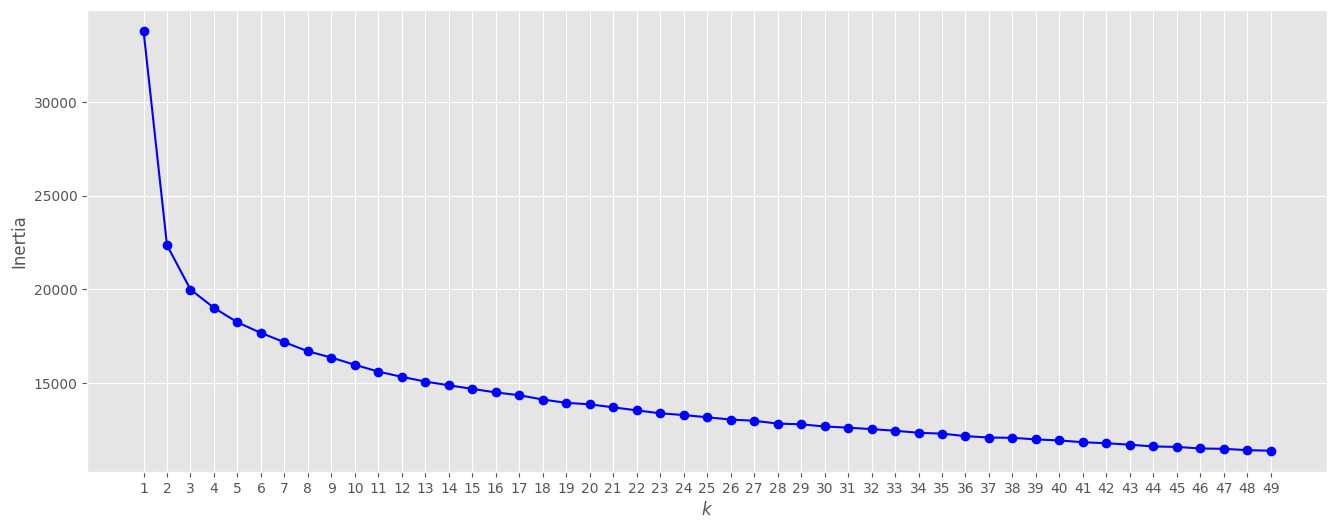

In [48]:
plt.figure(figsize=(16, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xticks(k_range)
plt.xlabel('$k$')
plt.ylabel('Inertia')
plt.show()

The goal of elbow method is to find the k value where inertia starts decreasing slowly. We can see from the chart that k=2 or k=3 are good choise of number of clusters.

However, this elbow technique for choosing the best value for the number of clusters is rather coarse, for this case, it is very hard to decide between k=2 and 3. So, we will also display the silhouette scores, which is a more precise (but also more computationally expensive) approach:

### silhouette score

In [49]:
#get the transformed data
retail_transformed = preprocessing.fit_transform(retail)
#calculate the silhouette scores
silhouette_scores = [silhouette_score(retail_transformed, 
                                      model[-1].labels_) for model in kmeans_per_k[1:]]

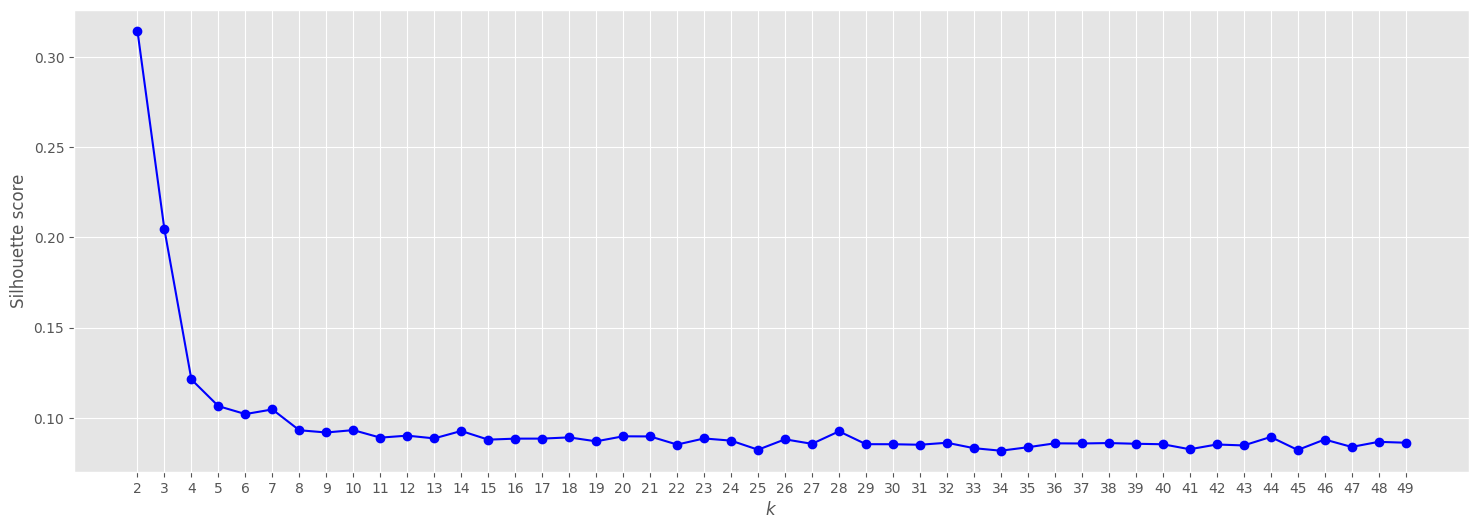

In [50]:
plt.figure(figsize=(18, 6))
plt.plot(k_range[1:], silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.xticks(k_range[1:])
plt.show()

As the silhouette scores suggest, k=2 is far better than k=3. Nevertheless, we will also create a silhouette diagram for a more informative visualization. In the silhouette diagram, each knife-shape’s height indicates the number of instances in the cluster, and its width represents the sorted silhouette coefficients of the instances in that cluster. And The vertical dashed lines represent the mean silhouette score for each number of clusters:

### Silhouette Diagram

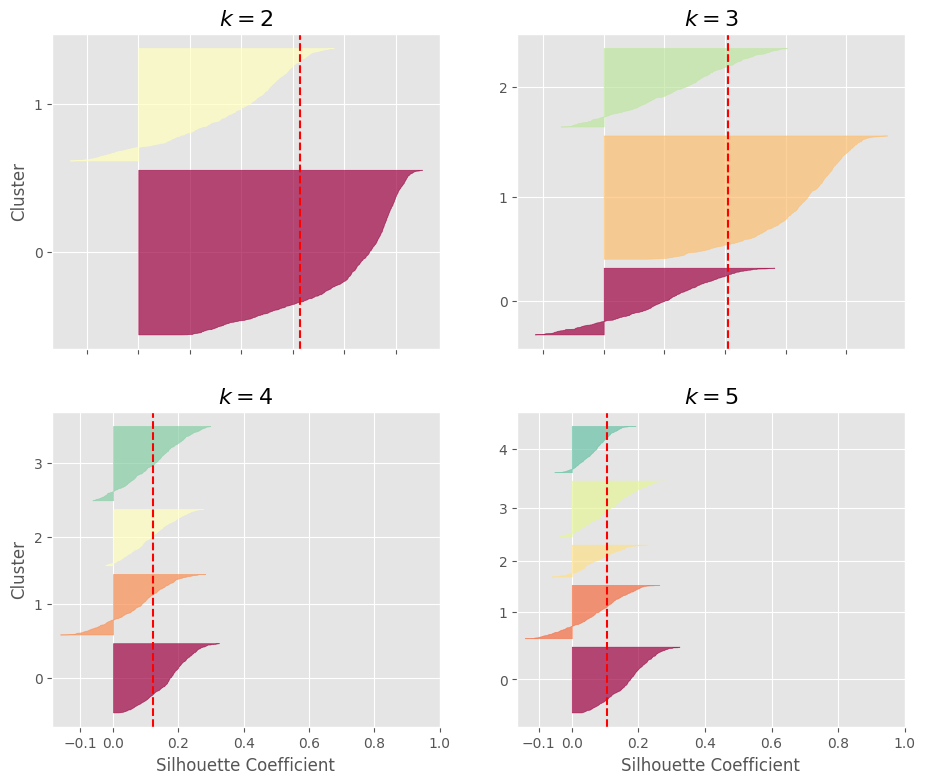

In [51]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1][-1].labels_
    silhouette_coefficients = silhouette_samples(retail_transformed, y_pred)

    padding = len(retail_transformed) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The silhouette diagram also suggest a preference of the number of clusters of 2 over 3 for two reasons: on the one hand, k=2 delivers a better silhouette score (dashed line) and on the other hand, when k=3, the clusters have very different size - the cluster at index 1 (the second from the bottom) is rather big.

Now that, we have decided the optimal the number of clusters as two, let's have a deeper look at the two clusters:

## Task 2
Describe the clusters found based on the characteristics of the attributes of the customers and the cluster size.

In [52]:
#get the kmeans (k=2) model
kmeans2 = kmeans_per_k[1][-1]

#have a look at the inertia of the model
kmeans2.inertia_

22348.288520326347

As the clusters are represented by their centroids, let's display the two cluster centers by wrapping them into a dataframe:

In [53]:
#centroids
pd.DataFrame(kmeans2.cluster_centers_, columns=preprocessing.get_feature_names_out())

,Education_Bachelor,Education_Basic,Education_Master,Education_PhD,Marital_Status_Relationship,Marital_Status_Single,Exist_Complain_0,Exist_Complain_1,Estimated_Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Member_days,Children,Age
0,0.483822,0.039127,0.267118,0.209932,0.659142,0.340858,0.990218,0.009782,-0.619937,-0.015024,-0.595203,-0.583433,-0.643867,-0.582969,-0.583258,-0.454174,-0.436502,-0.636224,-0.584025,-0.091512,0.40366,-0.090794
1,0.533040,0.002203,0.237885,0.226872,0.624449,0.375551,0.992291,0.007709,0.907374,0.021989,0.871173,0.853945,0.942399,0.853267,0.853689,0.664755,0.638890,0.931213,0.854812,0.133942,-0.59082,0.132891


Please note that the `cluster_centers_` attribute of the k-means model are the centroids of the transformed dataset, i.e. the values of the numerical columns are standardised, which makes it very difficult to directly interpret (for example an estimated income of -0.62, or a recency of 0.02 etc. which make no sense). Thus, we create a function below to transform the centroids (the values in their numerical columns to be specific) back to its original scale to ensure interpretability:

In [54]:
def get_centroids(k=2):
    '''
    outputs the unscaled cluster centers by specifying the number of clusters k.
    '''
    kmeans = kmeans_per_k[k-1][-1] #get the model with the specific k
    
    num_cols = preprocessing.get_feature_names_out()[-14:] #numerical columns
    cat_cols = preprocessing.get_feature_names_out()[:-14] #categorical columns
    centroids = pd.DataFrame(kmeans.cluster_centers_, 
                             columns=preprocessing.get_feature_names_out()) #the centroids with standardised values
    #sepatate the centroids by numerical and categorical columns, the values in categorical columns will stay unchanged
    cat_centroids = centroids[cat_cols] 
    num_centroids = centroids[num_cols]
    
    scaler = preprocessing.named_transformers_['remainder'] #get the standard scaler that previously transformed the data during fitting
    inverse_num_centroids = pd.DataFrame(scaler.inverse_transform(num_centroids), 
                                         columns=num_cols) #convert numerical columns of centroids to original scale
    inverse_centroids = pd.concat([cat_centroids, inverse_num_centroids], axis=1) #concatenate the columns
    
    return inverse_centroids

In [55]:
#display centroids in original scale
centroids_origin_scale = get_centroids(2)
centroids_origin_scale

,Education_Bachelor,Education_Basic,Education_Master,Education_PhD,Marital_Status_Relationship,Marital_Status_Single,Exist_Complain_0,Exist_Complain_1,Estimated_Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,Member_days,Children,Age
0,0.483822,0.039127,0.267118,0.209932,0.659142,0.340858,0.990218,0.009782,38893.190281,48.669676,105.196388,5.779533,35.801354,8.586907,5.878856,21.353273,2.907449,0.884876,3.896163,521.296464,1.254327,53.036117
1,0.533040,0.002203,0.237885,0.226872,0.624449,0.375551,0.992291,0.007709,70864.703786,49.741189,590.433921,44.926211,319.170705,66.530286,45.440529,65.991740,5.754405,5.170705,8.572687,566.859031,0.506608,55.653084


Now we have the centroids that are transformed back to the original scale for a better overview. The centroids represent a typical customer for each of the two clusters. And the values of the attributes are their interpretations.
1. We could describe a typical profile of the customers in cluster 0 as:
- has one or two children
- is around 53 years old
- well educated with a bachelor degree or above
- not single
- hasn't complainted within the last year
- has an estimated income of around 38893.19€
- became a customer about 521 day ago
- made last purchase about 49 days ago
- spent around 105.20€ on wine, 5.78€ on fruits, 35.80€ on meat, 8.59€ on fish, 5.88€ on sweets and 21.35€ on gold in the last 2 years
- made around 3 purchases through the company’s website, less than once using a catalog and nearly 4 directly in stores
2. We could describe a typical profile of the customers in cluster 1 as:
- tends to have no or only one children
- is around 55 years old
- well educated with a bachelor degree or above
- not single
- hasn't complainted within the last year
- has an estimated income of around 70864.70€
- became a customer about 567 day ago
- made last purchase about 50 days ago
- spent around 590.43€ on wine, 44.93€ on fruits, 319.17€ on meat, 66.53€ on fish, 45.44€ on sweets and 65.99€ on gold in the last 2 years
- made around 6 purchases through the company’s website, 5 using a catalog and nearly 9 directly in stores

Furthermore, if we compare the profiles of the two customer segments, we can find the major differences are:
- customers in cluster 1 tend to have more bachelor or phd degrees than those in cluster 0, whereas the basic education has more weight in customers of cluster 0;
- customers in cluster 0 have more children than those in cluster 1, which almost have no children;
- the income of customers in cluster 0 is significant lower;
- customers in cluster 1 have longer membership and spent several times more on all of the articles (such as wine, fruit, meat, fish, sweets and gold) in the last 2 years than those in cluster 0 did;
- the number of perchases on different channels (web, catalog and store purchases) made by customers in cluster 1 is more than twice of what customers in cluster 0 made

To further visualize the results of clustering, we create the following heatmap, which will display the difference between the two clusters as described above visually. To make the heatmap easier to read, we put all attributes on the same scale:

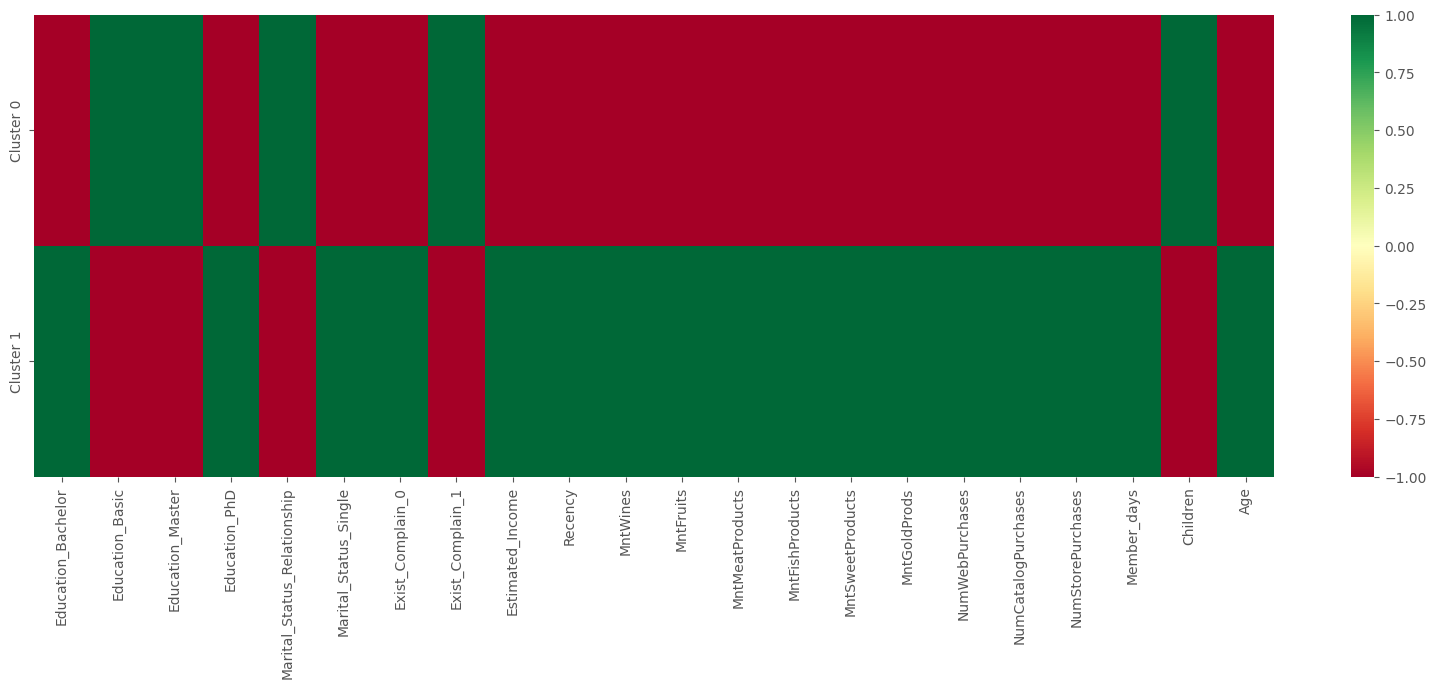

In [56]:
x_labels = preprocessing.get_feature_names_out() #the attributes
y_labels = ["Cluster 0","Cluster 1"] #two clusters

scaler = StandardScaler()
scaled_centroids = scaler.fit_transform(centroids_origin_scale) #scale the centroids
plt.figure(figsize=(20,6))
sns.heatmap(scaled_centroids, fmt='.2f', cmap='RdYlGn', xticklabels=x_labels, yticklabels=y_labels)
plt.show()

## Task 3
What recommendation could you give the marketing department based on your analysis?

According to the analysis above, customers in cluster 1 made far more purchases on average that those in cluster 0, hence, customers in cluster 1 should be the target customers.

- Firstly, the marketing department should in future identify the potential customers that belong to cluster 1 based on the profile analysed on task 2 (such as higher income, less children etc.) and make these the target segment; 
- Secondly, the marketing department should focus on this segment and launch different marketing campaign or activities, e.g., online and offline advertising, coupons, on different channels such as web, catalog and store.
- Lastly, after the customer segmentation is completed, the marketing department could, together with the data science department develop a recommender systems to suggest content that other users in the same cluster enjoyed.